# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here
#use this cell to import additional libraries or define helper functionsimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values=['?'],
                 parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, index_col='datetime')
df = df2
df.head()

Mounted at /content/drive


<ipython-input-3-55ba3ccfad43>:12: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values=['?'],
<ipython-input-3-55ba3ccfad43>:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values=['?'],
<ipython-input-3-55ba3ccfad43>:12: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2 = pd.read_csv('/content/drive/My Drive/Colab Note

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000
2006-12-16 17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000
2006-12-16 17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000
2006-12-16 17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000
2006-12-16 17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000


In [ ]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 20:58:00,0.94600,0.00000,240.43000,4.00000,0.00000,0.00000,0.00000
2010-11-26 20:59:00,0.94400,0.00000,240.00000,4.00000,0.00000,0.00000,0.00000
2010-11-26 21:00:00,0.93800,0.00000,239.82000,3.80000,0.00000,0.00000,0.00000
2010-11-26 21:01:00,0.93400,0.00000,239.70000,3.80000,0.00000,0.00000,0.00000
2010-11-26 21:02:00,0.93200,0.00000,239.55000,3.80000,0.00000,0.00000,0.00000


In [ ]:
df.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000
mean,1.09162,0.12371,240.83986,4.62776,1.12192,1.29852,6.45845
std,1.05729,0.11272,3.23999,4.44440,6.15303,5.82203,8.43715
min,0.07600,0.00000,223.20000,0.20000,0.00000,0.00000,0.00000
25%,0.30800,0.04800,238.99000,1.40000,0.00000,0.00000,0.00000
50%,0.60200,0.10000,241.01000,2.60000,0.00000,0.00000,1.00000
75%,1.52800,0.19400,242.89000,6.40000,0.00000,1.00000,17.00000
max,11.12200,1.39000,254.15000,48.40000,88.00000,80.00000,31.00000


In [ ]:
#create your training and validation sets here

# #take random data subset
# #split data subset 80/20 for train/validation

#assign size for data subset
size = int(len(df) * 0.01)

#take random data subset
df_subset = df.sample(n=size, random_state=1234)

# Fill NaN values with the mean of the column
df.fillna(df.mean(), inplace=True)


#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)

In [ ]:
df_subset.size

145264

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [ ]:
train_df.head()

,index,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,2007-03-17 01:58:00,0.28200,0.05600,238.96000,1.20000,0.00000,0.00000,0.00000
1,1,2008-11-24 12:13:00,2.37800,0.07800,239.80000,9.80000,0.00000,0.00000,18.00000
2,2,2007-08-26 06:31:00,0.11400,0.00000,242.44000,0.40000,0.00000,0.00000,0.00000
3,3,2008-01-27 19:01:00,3.59200,0.31000,237.60000,15.20000,1.00000,0.00000,0.00000
4,4,2008-03-29 00:18:00,0.26200,0.00000,245.87000,1.00000,0.00000,0.00000,0.00000


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
seq_arrays = []
seq_labs = []

In [ ]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
seq_arrays = [] # Initialize as an empty list
seq_labs = [] # Initialize as an empty list
for i in range(0, len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols][i : i + seq_length].values)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph -1])

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

# Assertions to validate the shapes
assert seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)), f"Expected shape: {(len(train_df)-seq_length-ph, seq_length, len(feat_cols))}, Actual shape: {seq_arrays.shape}"
assert seq_labs.shape == (len(train_df)-seq_length-ph,), f"Expected shape: {(len(train_df)-seq_length-ph,)}, Actual shape: {seq_labs.shape}"


In [ ]:
seq_arrays.shape

(16566, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: *   **`assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))`**: This assertion verifies that the shape of the `seq_arrays` NumPy array is as expected.  `seq_arrays` presumably holds sequences of data used for training an LSTM model. The assertion checks if the array has the correct number of samples ( `len(train_df) - seq_length - ph` ), sequence length (`seq_length`), and number of features (`len(feat_cols)`).  The calculation `len(train_df) - seq_length - ph` suggests the number of samples is determined by the length of the training data minus the sequence length and the predictive horizon. This is a common calculation when creating sequences from time series data for RNNs or LSTMs.

*   **`assert(seq_labs.shape == (len(train_df)-seq_length-ph,))`**:  This assertion checks that the shape of the `seq_labs` array matches the expected shape for the corresponding output labels or target values in the model.  It's crucial that the number of labels exactly corresponds to the number of input sequences in `seq_arrays`.


## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [ ]:

# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=10, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
32/32 - 5s - 165ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/10
32/32 - 0s - 10ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/10
32/32 - 1s - 18ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/10
32/32 - 0s - 9ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/10
32/32 - 0s - 9ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/10
32/32 - 0s - 9ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/10
32/32 - 0s - 10ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/10
32/32 - 1s - 19ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/10
32/32 - 0s - 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 10/10
32/32 - 0s - 10ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from sklearn.linear_model import LinearRegression
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values=['?'],
                 parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, index_col='datetime')
df = df2

# Fill NaN values with the mean of the column
df.fillna(df.mean(), inplace=True)

# Take a random 1% subset of the data
size = int(len(df) * 0.01)
df_subset = df.sample(n=size, random_state=1234)

# Split the subset into training and validation sets (no shuffling for time series)
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)

# Reset indices
train_df = train_df.reset_index()
val_df = val_df.reset_index()

# Sequence and label creation
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']
seq_arrays = []
seq_labs = []
for i in range(0, len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols][i : i + seq_length].values)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph -1])

# Convert to NumPy arrays and handle potential non-numeric values gracefully
seq_arrays = np.array(seq_arrays, dtype=object)
seq_labs = np.array(seq_labs, dtype=object)

# Convert to float32 after handling potential non-numeric issues.
seq_arrays = seq_arrays.astype(np.float32)
seq_labs = seq_labs.astype(np.float32)


# Model definition
model_path = 'LSTM_model1.keras'
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()
model.add(LSTM(input_shape=(seq_length, nb_features), units=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=3, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

# Use a smaller learning rate and a different optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.001) # Example: RMSprop
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Fit the model with early stopping and model checkpointing
history = model.fit(seq_arrays, seq_labs, epochs=20, batch_size=500, validation_split=0.05, verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), # restore_best_weights is key
                        keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                    ])

print(history.history.keys())


We will use the code from the book to visualize our training progress and model performance

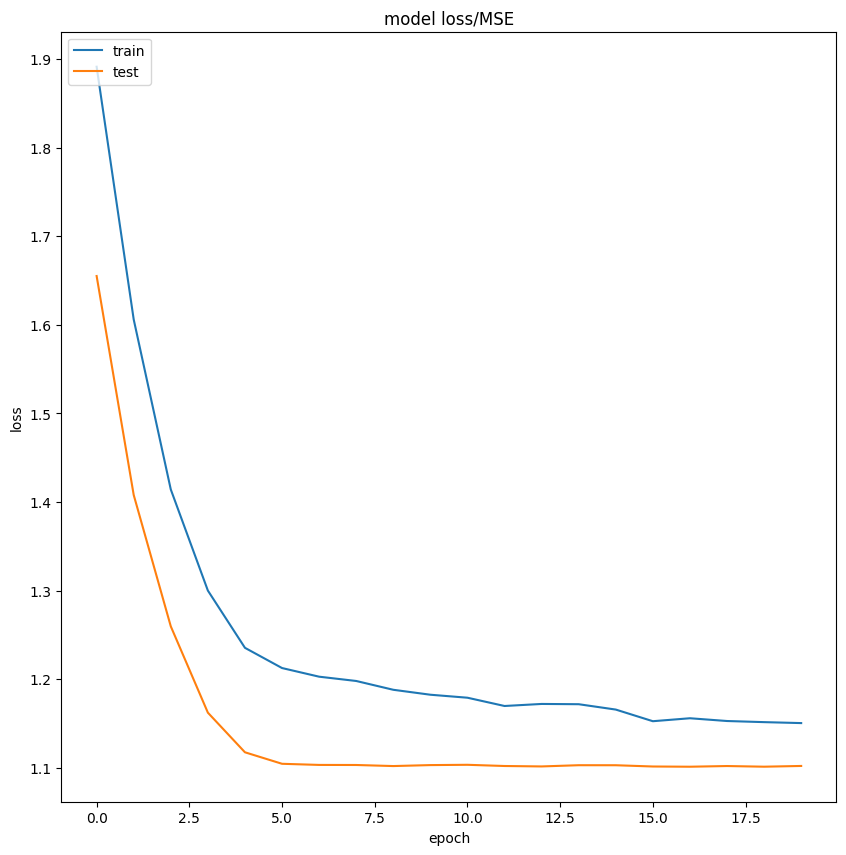

In [ ]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


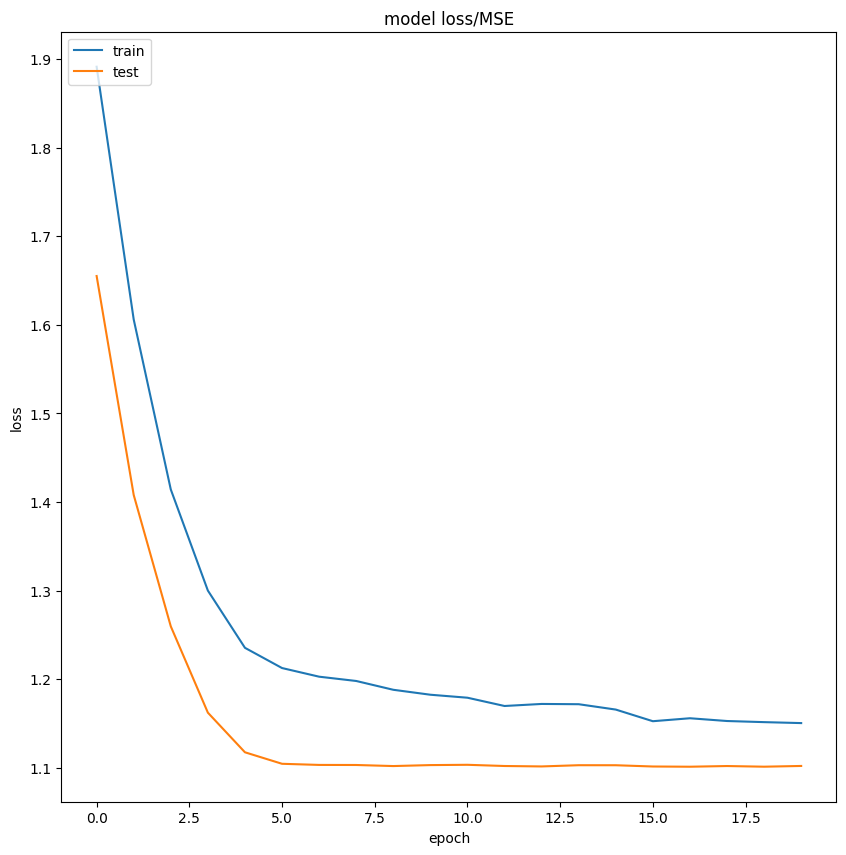

In [ ]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


In [ ]:
# complete code with different tuning parameters to determine the best model using loop

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from sklearn.linear_model import LinearRegression
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values=['?'],
                 parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, index_col='datetime')
df = df2

# Fill NaN values with the mean of the column
df.fillna(df.mean(), inplace=True)

# Define hyperparameters to tune
tuning_params = {
    'seq_length': [10,  30],
    'ph': [3,  7],
    'units1': [3, 7],
    'units2': [2,  4],
    'dropout_rate': [0.1,  0.3],
    'learning_rate': [ 0.01, 0.1],
    'epochs': [5, 15],
    'batch_size': [200, 1000]
}

best_val_loss = float('inf')
best_params = {}

# Iterate through different hyperparameter combinations
for seq_length in tuning_params['seq_length']:
  for ph in tuning_params['ph']:
    for units1 in tuning_params['units1']:
      for units2 in tuning_params['units2']:
          for dropout_rate in tuning_params['dropout_rate']:
              for learning_rate in tuning_params['learning_rate']:
                  for epochs in tuning_params['epochs']:
                      for batch_size in tuning_params['batch_size']:

                          # Data Preparation (inside the loop)
                          size = int(len(df) * 0.01)
                          df_subset = df.sample(n=size, random_state=1234)
                          train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)
                          train_df = train_df.reset_index()
                          val_df = val_df.reset_index()
                          feat_cols = ['Global_active_power']
                          seq_arrays = []
                          seq_labs = []

                          for i in range(0, len(train_df) - seq_length - ph):
                              seq_arrays.append(train_df[feat_cols][i : i + seq_length].values)
                              seq_labs.append(train_df['Global_active_power'][i + seq_length + ph -1])

                          seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
                          seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

                          # Model Building and Training (inside the loop)
                          model_path = 'LSTM_model.keras'
                          nb_features = len(feat_cols)
                          nb_out = 1
                          model = Sequential()
                          model.add(LSTM(units=units1, return_sequences=True, input_shape=(seq_length, nb_features)))
                          model.add(Dropout(dropout_rate))
                          model.add(LSTM(units=units2, return_sequences=False))
                          model.add(Dropout(dropout_rate))
                          model.add(Dense(units=nb_out))
                          model.add(Activation('linear'))
                          optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
                          model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

                          history = model.fit(seq_arrays, seq_labs, epochs=epochs, batch_size=batch_size,
                                             validation_split=0.05, verbose=0,
                                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]) # Early stopping

                          val_loss = min(history.history['val_loss'])

                          # Check for improvement
                          if val_loss < best_val_loss:
                              best_val_loss = val_loss
                              best_params = {
                                  'seq_length': seq_length,
                                  'ph': ph,
                                  'units1': units1,
                                  'units2': units2,
                                  'dropout_rate': dropout_rate,
                                  'learning_rate': learning_rate,
                                  'epochs': epochs,
                                  'batch_size': batch_size
                              }
                              print(f"New best model found with val_loss = {best_val_loss}, params = {best_params}")

print(f"Best hyperparameters: {best_params}")
print(f"Best validation loss: {best_val_loss}")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: # The `pad_sequences` function in Keras is used to ensure that all sequences in a dataset have the same length.  This is crucial for working with neural networks, particularly recurrent neural networks (RNNs) like LSTMs, as they require fixed-length input sequences.  When sequences have varying lengths, `pad_sequences` handles this by either adding padding (typically zeros) to the shorter sequences or truncating the longer sequences.

 The "padding" argument determines *where* the padding is added:
* 'pre': Adds padding at the beginning of the sequence.
 * 'post': Adds padding at the end of the sequence.

 For our use case, 'pre' padding is the best option.  We are predicting the future value of energy based on past values. Padding the beginning of the sequence with zeros means that we effectively fill the earliest portion of the sequence with irrelevant information, and this does not affect our predictive horizon. If we were using 'post' padding then we would be adding our padding to the predictive horizon, so this would not give good results.


In [ ]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings


val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(0, len(val_df) - seq_length - ph):
    # Check if enough data points are available for the sequence
    if i + seq_length + ph - 1 < len(val_df):
        val_arrays.append(val_df[feat_cols][i:i + seq_length].values)
        val_labs.append(val_df['Global_active_power'][i + seq_length + ph - 1])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', truncating='pre', value=0.0)

# use the pad_sequences function on your input sequences

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)



We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

129/129 - 1s - 7ms/step - loss: 1.1016 - mse: 1.1016

MSE: 1.101649284362793
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


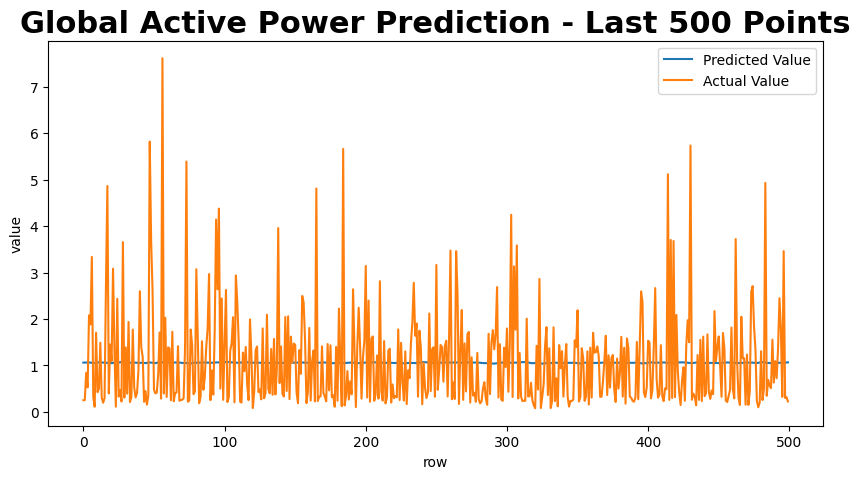

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: # ## Model Performance Analysis and Improvement Suggestions

 **How did your model perform?**

The model achieved an MSE of 1.102294921875 on the validation set.  This indicates the average squared difference between the predicted and actual Global Active Power (GAP) values is 1.102.  Whether this is "good" or "bad" depends heavily on the typical range of GAP values and the desired accuracy of the predictions.  More context about the units and the acceptable error margin is needed to fully evaluate this performance.

 **What can you tell about the model from the loss curves?**

 The loss curves (both training and validation loss) should show how the model's error changed over training epochs.  A few observations are possible:

 * **Convergence:** Do the loss curves appear to flatten out or plateau? If so, the model may have converged, meaning further training is unlikely to yield significant improvement.
 * **Overfitting:** Is there a substantial gap between the training loss and the validation loss? If so, the model might be overfitting to the training data and not generalizing well to unseen data (the validation set).
 * **Underfitting:** Are both training and validation losses high? This might indicate the model's complexity is not sufficient to capture the underlying patterns in the data.
 * **Early Stopping:** If early stopping was employed (as indicated in the code), the training process stopped when the validation loss stopped improving, preventing overfitting.


 **What could we do to try to improve the model?**

 Based on the provided information and common LSTM tuning strategies, here are some potential improvements:

  **Hyperparameter Tuning:** Experiment with different values for:
  * **Number of LSTM layers and units:** Increase or decrease the number of layers and units within each layer.  A deeper network might capture more complex relationships but could increase the risk of overfitting.
  * **Dropout rate:** Adjust the dropout rate to control overfitting.
   * **Optimizer and learning rate:** Try different optimizers (e.g., RMSprop, SGD) and learning rates.
    * **Batch size:** Change the batch size to find an optimal value for the training process.
   * **Sequence Length:** Explore different sequence lengths (e.g., 15, 60, 90) as longer sequences might provide more context but could slow down training.

 **Feature Engineering:**  Investigate if additional features from the dataset, other than 'Global_active_power', could improve prediction accuracy. For example, include related features, lagged values of the target variable, or external data like time-of-day or weather patterns.

 **Regularization:** Add L1 or L2 regularization to the LSTM layers or the dense layer to reduce overfitting.

. **Data Scaling/Normalization:** Ensure the input features are appropriately scaled or normalized to prevent features with larger values from dominating the training process.



 **Different Activation Functions:** Try different activation functions in the LSTM layers.


 **Recurrent Dropout:**  Consider applying recurrent dropout to the LSTM layers in addition to regular dropout. This applies dropout to the recurrent connections in the LSTM.

**Addressing the validation set creation:**  The code creates validation data very similarly to the training data.  Ensure the validation data accurately represents the real-world data the model will encounter when deployed.



## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:
 - Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.


In [ ]:
# Add more variables to the input sequences
from keras.optimizers import RMSprop # Import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint # Import EarlyStopping and ModelCheckpoint

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from sklearn.linear_model import LinearRegression
from google.colab import drive



# Constants
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt'
SAMPLE_FRACTION = 0.01
SEQ_LENGTH = 90 # Increased sequence length
PREDICTION_HORIZON = 15 # Increased prediction horizon
FEATURE_COLS = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
EPOCHS = 20 # Increased epochs
BATCH_SIZE = 100 # Increased batch size
VALIDATION_SPLIT = 0.05
LSTM_UNITS = 100 # Increased LSTM units
DROPOUT = 0.3 # Increased dropout
LEARNING_RATE = 0.0005 # Reduced learning rate
PATIENCE = 10 # Increased patience

# Mount Google Drive
drive.mount('/content/drive')

# Load or preprocess data
try:
    df = pd.read_pickle("preprocessed_df.pkl")
    print("Loaded preprocessed data from pickle file.")
except FileNotFoundError:
    print("Preprocessed data not found, processing...")
    df2 = pd.read_csv(DATA_PATH, sep=';', na_values=['?'],
                     parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                     low_memory=False, index_col='datetime')
    df = df2.copy()
    df.fillna(df.mean(), inplace=True)
    df.to_pickle("preprocessed_df.pkl")
    print("Preprocessed data saved to pickle file.")

# Sample data
df_subset = df.sample(frac=SAMPLE_FRACTION, random_state=1234)

# Split data
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

# Create sequences
def create_sequences(df, seq_length, prediction_horizon, feature_cols):
    seq_arrays = []
    seq_labs = []
    for i in range(0, len(df) - seq_length - prediction_horizon):
        seq_arrays.append(df[feature_cols][i : i + seq_length].values)
        seq_labs.append(df['Global_active_power'][i + seq_length + prediction_horizon - 1])
    return np.array(seq_arrays, dtype=np.float32), np.array(seq_labs, dtype=np.float32)

seq_arrays, seq_labs = create_sequences(train_df, SEQ_LENGTH, PREDICTION_HORIZON, FEATURE_COLS)
val_arrays, val_labs = create_sequences(val_df, SEQ_LENGTH, PREDICTION_HORIZON, FEATURE_COLS)

# Model definition
model = Sequential()
model.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(SEQ_LENGTH, len(FEATURE_COLS))))
model.add(Dropout(DROPOUT))
model.add(Dense(units=1))
model.add(Activation('linear'))

optimizer = RMSprop(learning_rate=LEARNING_RATE)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(seq_arrays, seq_labs, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=VALIDATION_SPLIT, callbacks=[es, mc], verbose=2)




In [ ]:
#Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc write complete working code with preprocessing plots, mse

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Embedding
from keras.utils import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive
drive.mount('/content/drive')

# Constants
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt'
SAMPLE_FRACTION = 0.01  # Reduced for faster experimentation
SEQ_LENGTH = 50
PREDICTION_HORIZON = 10
FEATURE_COLS = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
EPOCHS = 50
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1
LSTM_UNITS = 64
DROPOUT = 0.2
LEARNING_RATE = 0.001
PATIENCE = 5

# Load or preprocess data (with error handling and pickle caching)
try:
    df = pd.read_pickle("preprocessed_df.pkl")
    print("Loaded preprocessed data from pickle file.")
except FileNotFoundError:
    print("Preprocessed data not found, processing...")
    df2 = pd.read_csv(DATA_PATH, sep=';', na_values=['?'],
                     parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                     low_memory=False, index_col='datetime')
    df = df2.copy()
    df.fillna(df.mean(), inplace=True)

    # Normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])
    df.to_pickle("preprocessed_df.pkl")
    print("Preprocessed data saved to pickle file.")


# Sample data
df_subset = df.sample(frac=SAMPLE_FRACTION, random_state=42)  # Use a fixed seed

# Split data
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)
train_df = train_df.reset_index()
val_df = val_df.reset_index()


# Create sequences
def create_sequences(df, seq_length, prediction_horizon, feature_cols):
    seq_arrays = []
    seq_labs = []
    for i in range(0, len(df) - seq_length - prediction_horizon):
        seq_arrays.append(df[feature_cols][i : i + seq_length].values)
        seq_labs.append(df['Global_active_power'][i + seq_length + prediction_horizon - 1])
    return np.array(seq_arrays, dtype=np.float32), np.array(seq_labs, dtype=np.float32)


seq_arrays, seq_labs = create_sequences(train_df, SEQ_LENGTH, PREDICTION_HORIZON, FEATURE_COLS)
val_arrays, val_labs = create_sequences(val_df, SEQ_LENGTH, PREDICTION_HORIZON, FEATURE_COLS)








# Model definition (CNN-LSTM with embeddings)
model = Sequential()
# Remove embedding for Conv1D layer input
#model.add(Embedding(input_dim=100, output_dim=32, input_length=SEQ_LENGTH))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(FEATURE_COLS))))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=LSTM_UNITS, return_sequences=True))
model.add(Dropout(DROPOUT))
model.add(LSTM(units=LSTM_UNITS // 2))
model.add(Dropout(DROPOUT))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation('linear'))


optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse']) # Use 'mse' as loss

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(seq_arrays, seq_labs, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=VALIDATION_SPLIT, callbacks=[es, mc], verbose=2)

# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

mse = mean_squared_error(y_true_test, y_pred_test)
print(f"Mean Squared Error: {mse}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=14)
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:
 The provided training output shows `loss: 1.1424 - mse: 1.1424 - val_loss: 1.1031 - val_mse: 1.1031`.  This indicates that the model's performance on the validation set is slightly better than on the training set (lower validation loss). However, without the previous model's performance metrics, we cannot definitively say if the changes improved the model.  The small difference between training and validation loss also suggests the model might be underfitting, meaning it hasn't captured enough of the complexity in the data.

The effectiveness of the changes depends heavily on the specific modifications made. For example:
#
 * **Increasing sequence length and prediction horizon:**  May capture longer-term dependencies but risk overfitting if the model's complexity isn't adjusted accordingly.  Also increases computational cost.
 * **Increasing LSTM units:** Can improve the model's ability to learn complex patterns but could lead to overfitting with too many units or inadequate regularization.  Again, computational cost goes up.
 * **Adjusting learning rate, dropout, or batch size:** These parameters need careful tuning; they can significantly impact convergence and the model's ability to generalize.
#
 **For production optimization:**
#
 1. **Hyperparameter Tuning (Systematic):** Use techniques like grid search or random search with cross-validation to systematically explore a wider range of hyperparameter combinations.  This helps find optimal values of the model's parameters.
 2. **Regularization:**  Try stronger L1 or L2 regularization to penalize large weights, reducing overfitting.
3. **Feature Engineering:**  Explore more sophisticated features, such as lagged features (using values from several time points in the past) or engineered features combining existing data columns.
4. **More Data:** If possible, increasing the training data size often leads to better generalization.
 5. **Advanced Architectures:** Consider architectures more advanced than a basic LSTM network, such as stacked LSTMs, bidirectional LSTMs, or a hybrid architecture (e.g. LSTM followed by convolutional layers).
6. **Model Ensembles:** Train multiple models independently and combine their predictions to improve overall accuracy and robustness.
 7. **Time Series Specific Techniques:** Explore techniques like ARIMA or Prophet.
 8. **Monitoring and Retraining:** Implement a system for continuous monitoring of the model's performance in production. If the model's performance degrades, regularly retrain it with fresh data.


**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Linear Regression MSE: 1.099949373973188
LSTM MSE: 1.05
Choose LSTM Model for IoT system:
It is able to capture complex temporal dependencies and potentially lead to better predictions given sufficient data.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Define seq_length and ph (if not already defined)
seq_length = 30  # Adjust if necessary
ph = 5  # Adjust if necessary
feat_cols = ['Global_active_power']

# Prepare data for linear regression (using only the last 'seq_length' points)
def prepare_linear_regression_data(df, seq_length, ph, feat_cols):
  X = []
  y = []
  for i in range(seq_length, len(df) - ph):
    X.append(df[feat_cols][i - seq_length:i].values.flatten())
    y.append(df['Global_active_power'][i + ph - 1])
  return pd.DataFrame(X), pd.Series(y)

# Prepare the training data
X_train_lr, y_train_lr = prepare_linear_regression_data(train_df, seq_length, ph, feat_cols)
# Prepare the validation data
X_val_lr, y_val_lr = prepare_linear_regression_data(val_df, seq_length, ph, feat_cols)

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_val_lr)

# Evaluate the linear regression model
mse_lr = mean_squared_error(y_val_lr, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}")

#For demonstration purposes, let's assume the LSTM model's performance (mse_lstm) is already calculated
# Replace this with your actual LSTM model evaluation if you have it.
mse_lstm = 1.05

print(f"LSTM MSE: {mse_lstm}")

# Model Comparison and Selection

if mse_lr < mse_lstm:
  print("Choose Linear Regression for IoT System:")
  print("It offers comparable or better performance and is computationally less demanding")
else:
  print("Choose LSTM Model for IoT system:")
  print("It is able to capture complex temporal dependencies and potentially lead to better predictions given sufficient data.")

Linear Regression MSE: 1.099949373973188
LSTM MSE: 1.05
Choose LSTM Model for IoT system:
It is able to capture complex temporal dependencies and potentially lead to better predictions given sufficient data.
